## EDA - Timeseries 


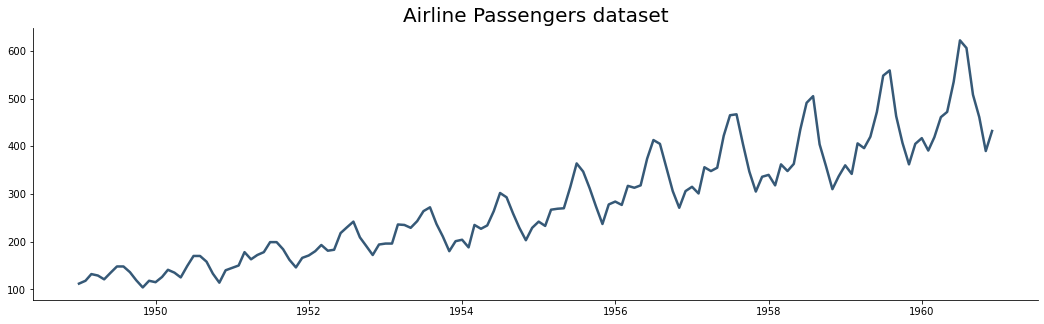

In [7]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5


# Dataset
df = pd.read_csv('dataset/airline-passengers.csv', index_col='Month', parse_dates=True)

# Visualize
plt.title('Airline Passengers dataset', size=20)
plt.plot(df);

### Yearly seasonality
- How correlated the number of passengers this month is to the number of passengers a year ago?

### Autocorrelation 
 - Before calculating autocorrelation, make the time series stationary (We will revisit in the later part). 
 - Making time series stationary is by calculating the first-order difference.
 - In general, the mean, variance, and covariance shouldn’t change over time.

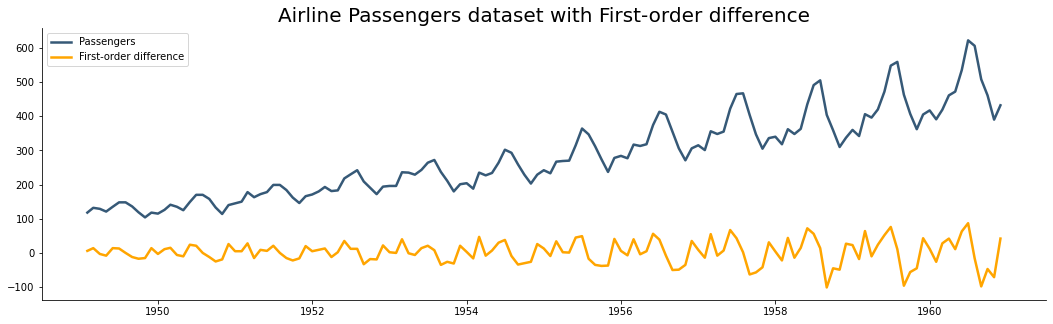

In [8]:
# First-order difference
df['Passengers_Diff'] = df['Passengers'].diff(periods=1)
df = df.dropna()

# Plot
plt.title('Airline Passengers dataset with First-order difference', size=20)
plt.plot(df['Passengers'], label='Passengers')
plt.plot(df['Passengers_Diff'], label='First-order difference', color='orange')
plt.legend();

In [9]:
# Calculate autocorrelation
acf_values = acf(df['Passengers_Diff'], nlags=30)

/Users/shankar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [10]:
np.round(acf_values,2)

array([ 1.  ,  0.3 , -0.1 , -0.24, -0.3 , -0.09, -0.08, -0.09, -0.29,
       -0.19, -0.1 ,  0.28,  0.83,  0.28, -0.11, -0.22, -0.23, -0.06,
       -0.07, -0.09, -0.3 , -0.16, -0.08,  0.26,  0.7 ,  0.26, -0.1 ,
       -0.2 , -0.17, -0.07, -0.04])

The first value is 1, because a correlation between two identical series was calculated. But take a look at as 12th period — autocorrelation value is 0.83. This tells you a value 12 periods ago has a strong impact on the value today.


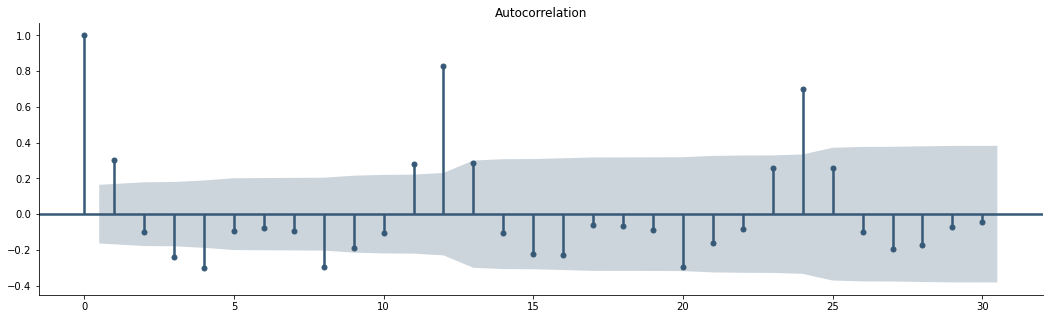

In [11]:
# Plot autocorrelation
plot_acf(df['Passengers_Diff'], lags=30);

The plot confirms our assumption about the correlation on lag 12. The same is visible at lag 24, but the correlation declines over time. Value 12 periods ago has more impact on the value today than value 24 periods ago does.

## Stationarity Test
- A simple hypothesis testing: **Null hypothesis (H0)** — Time series is not stationary. **Alternative hypothesis (H1)** — Time series is stationary.

### Dicky-Fuller test 
- If the returned P-value is higher than 0.05, the time series isn’t stationary. 0.05 is the standard threshold, but you’re free to change it.

In [12]:
adfuller(df['Passengers'])

(0.7923399959692509,
 0.9915115096288659,
 13,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 989.880197755545)

In [13]:
def make_stationary(data: pd.Series, alpha: float = 0.05, max_diff_order: int = 10) -> dict:
    # Test to see if the time series is already stationary
    if adfuller(data)[1] < alpha:
        return {
            'differencing_order': 0,
            'time_series': np.array(data)
        }
    
    # A list to store P-Values
    p_values = []
    
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        # Perform ADF test
        result = adfuller(data.diff(i).dropna())
        # Append P-value
        p_values.append((i, result[1]))
        
    # Keep only those where P-value is lower than significance level
    significant = [p for p in p_values if p[1] < alpha]
    # Sort by the differencing order
    significant = sorted(significant, key=lambda x: x[0])
    
    # Get the differencing order
    diff_order = significant[0][0]
    
    # Make the time series stationary
    stationary_series = data.diff(diff_order).dropna()
    
    return {
        'differencing_order': diff_order,
        'time_series': np.array(stationary_series)
    }

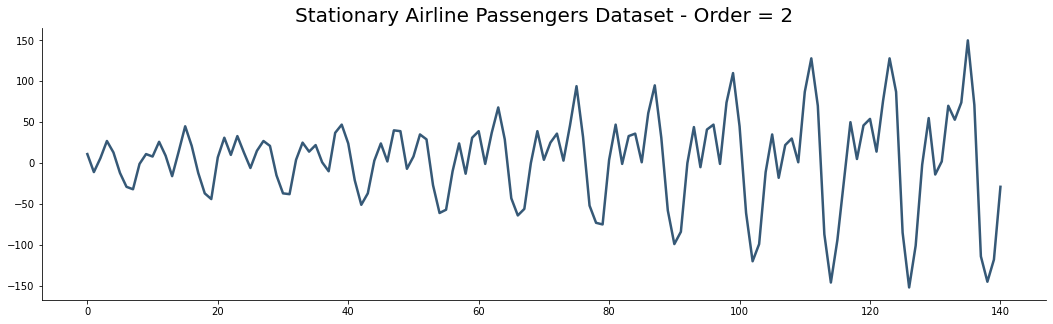

In [14]:
ap_stationary = make_stationary(
    data=df['Passengers']
)

plt.title(f"Stationary Airline Passengers Dataset - Order = {ap_stationary['differencing_order']}", size=20)
plt.plot(ap_stationary['time_series']);

## Train Test Split In TS
- In machine learning, train/test split splits the data randomly, as there’s no dependence from one observation to the other. 
- While in time series data, you’ll want to use values at the rear of the dataset for testing and everything else for training.

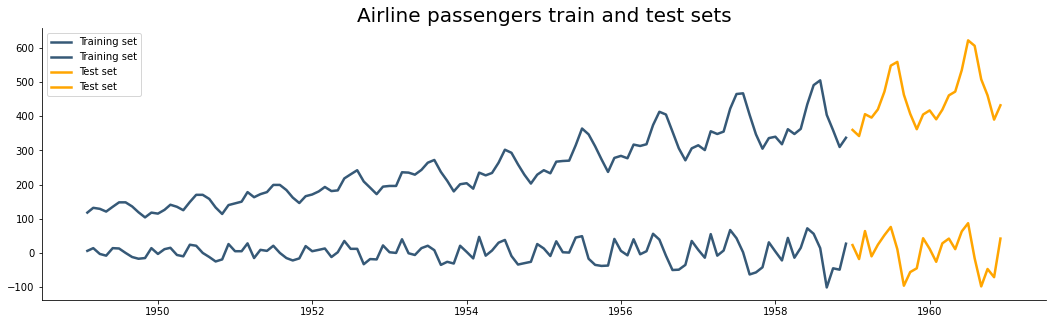

In [16]:
#Slicing the train-test data
test_size = 24

df_train = df[:-test_size]
df_test = df[-test_size:]

plt.title('Airline passengers train and test sets', size=20)
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.legend();

## General regression metrics used for evaluating TS
- MAE, MSE, or RMSE
- RMSE — Root Mean Squared Error
- MAPE — Mean Absolute Percentage Error

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))

# Arbitrary data
actual_passengers = [300, 290, 320, 400, 500, 350]
predicted_passengers = [291, 288, 333, 412, 488, 344]

# Error metrics
print(f'RMSE: {rmse(actual_passengers, predicted_passengers)}')
print(f'MAPE: {mean_absolute_percentage_error(actual_passengers, predicted_passengers)}')


RMSE: 9.814954576223638
MAPE: 0.024777401477832514


**Inference:** On an average month, the predictions are off by 10 passenger units (thousands), or around 2.5%.

### Moving Average


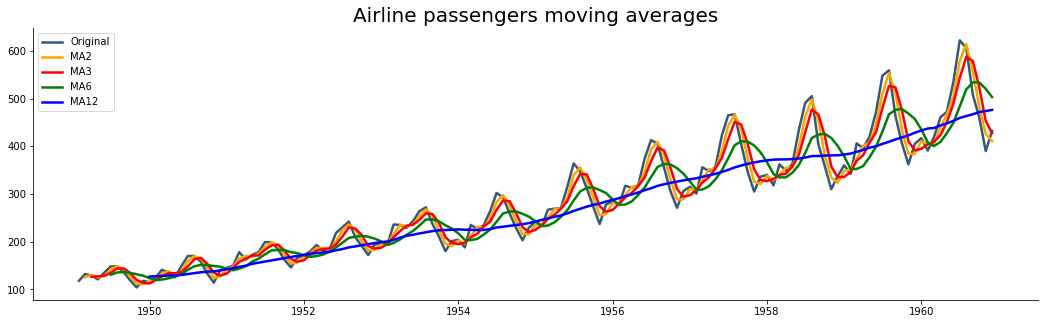

In [21]:
# Calculate
df['MA2'] = df['Passengers'].rolling(window=2).mean()
df['MA3'] = df['Passengers'].rolling(window=3).mean()
df['MA6'] = df['Passengers'].rolling(window=6).mean()
df['MA12'] = df['Passengers'].rolling(window=12).mean()

# Plot
plt.title('Airline passengers moving averages', size=20)
plt.plot(df['Passengers'], label='Original')
plt.plot(df['MA2'], color='orange', label='MA2')
plt.plot(df['MA3'], color='red', label='MA3')
plt.plot(df['MA6'], color='green', label='MA6')
plt.plot(df['MA12'], color='blue', label='MA12')
plt.legend();

Problems with simple moving average:
- **Lag** — moving average time series always lags from the original one. Look at the peaks to verify that claim.
- **Noise** — too small sliding window size won’t remove all noise from the original data.
- **Averaging issue** — averaged data will never capture the low and high points of the original series.
- **Weighting** — identical weights are assigned to all data points. This can be an issue as frequently the most recent values have more impact on the future.

### Using Moving Average for Forecasting
- We build model using ARMA
- The last two years (24 rows) are used for testing.

In [26]:
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)

/Users/shankar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37877D+00    |proj g|=  2.24718D-02

At iterate    5    f=  5.36724D+00    |proj g|=  6.03606D-04

At iterate   10    f=  5.36590D+00    |proj g|=  5.80869D-05

At iterate   15    f=  5.36590D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     22      1     0     0   0.000D+00   5.366D+00
  F =   5.3659035225147242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


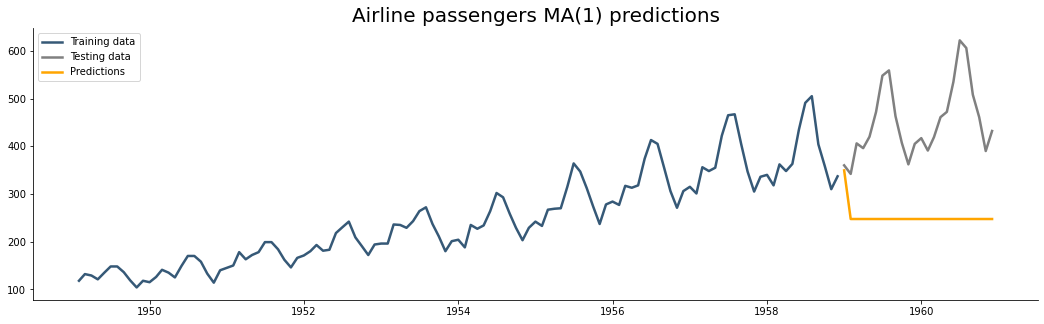

In [29]:


# Train/test split
df_train = df[:-24]
df_test = df[-24:]

# Train the model
model = ARMA(df_train['Passengers'], order=(0, 1))
results = model.fit()
predictions = results.forecast(steps=24)
predictions_df = pd.DataFrame(index=df_test.index, data=predictions[0])

# Plot
plt.title('Airline passengers MA(1) predictions', size=20)
plt.plot(df_train['Passengers'], label='Training data')
plt.plot(df_test['Passengers'], color='gray', label='Testing data')
plt.plot(predictions_df, color='orange', label='Predictions')
plt.legend();

Inference: Simple moving averages aren’t the best forecasting model. (EWMA is better)